# Evolutionary Computation Assignment 1

- Krzysztof Szala 144571
- Vadym Repetskyi 155610


In [1]:
from utils import TspInstance
import math
import numpy as np
import pandas as pd

tsp_a = TspInstance("TSPA.csv")
tsp_b = TspInstance("TSPB.csv")

## Problem Instance Comparison


In [2]:
print("Average cost for an instance A:", np.mean(tsp_a.node_costs))
print("Average cost for an instance B:", np.mean(tsp_b.node_costs))

Average cost for an instance A: 978.165
Average cost for an instance B: 494.58


## Random Solution

Randomly select half of the nodes and shuffle them.


In [3]:
def random_solution(tsp: TspInstance, _: int):
    num_nodes = tsp.distance_matrix.shape[0]
    num_nodes_to_select = math.ceil(num_nodes / 2)
    selected_nodes = np.random.choice(num_nodes, num_nodes_to_select, replace=False)
    return selected_nodes

## Nearest Neighbor End

1. Start path with a random node.
2. While there are nodes to add:
   1. Evaluate the cost increase each remaining node will introduce if added to the end of the path.
   2. Add node which increases the cost the least

`Cost Difference = Cost(New) + Distance(Last, New)`


In [4]:
def nearest_neighbor_end(tsp: TspInstance, start_node: int):
    solution = [start_node]

    while len(solution) < np.ceil(tsp.size / 2):
        selected_node_index = min_cost = None

        for node_index in range(tsp.size):
            if node_index in solution:
                continue

            cost = (
                tsp.node_costs[node_index]
                + tsp.distance_matrix[solution[-1]][node_index]
            )

            if min_cost is None or cost < min_cost:
                selected_node_index = node_index
                min_cost = cost

        solution.append(selected_node_index)

    return solution

## Nearest Neighbor Any

1. Start path with a random node.
2. While there are nodes to add:
   1. Evaluate the cost increase each remaining node will introduce if added to **_arbitrary position_**.
   2. Insert the node which increases the cost the least in the specified point.

`Cost Difference = Cost(New) + Distance(Previous, New) + Distance(New, Next) - Distance(Previous, Next)`


In [5]:
def nearest_neighbor_any(tsp: TspInstance, start_node: int):
    solution = [start_node]

    while len(solution) < np.ceil(tsp.size / 2):
        selected_node_index = selected_path_index = min_cost = None

        for node_index in range(tsp.size):
            if node_index in solution:
                continue

            for insertion_index in range(len(solution) + 1):
                if insertion_index == 0:
                    cost = (
                        tsp.node_costs[node_index]
                        + tsp.distance_matrix[node_index][solution[0]]
                    )
                elif insertion_index == len(solution):
                    cost = (
                        tsp.node_costs[node_index]
                        + tsp.distance_matrix[solution[-1]][node_index]
                    )
                else:
                    start = solution[insertion_index - 1]
                    end = solution[insertion_index]
                    cost = (
                        tsp.node_costs[node_index]
                        + tsp.distance_matrix[start][node_index]
                        + tsp.distance_matrix[node_index][end]
                        - tsp.distance_matrix[start][end]
                    )

                if min_cost is None or cost < min_cost:
                    selected_node_index = node_index
                    selected_path_index = insertion_index
                    min_cost = cost

        solution.insert(selected_path_index, selected_node_index)

    return solution

## Greedy cycle

1. Initialize the **_cycle_** with a random node and another node closest to it.
2. While there are nodes to add:
   1. Evaluate the cost increase each remaining node will introduce if added to **_arbitrary position_**.
   2. Insert the node which increases the cost the least in the specified point.

`Cost Difference = Cost(New) + Distance(Previous, New) + Distance(New, Next) - Distance(Previous, Next)`

It is different from NN-Any, because for this method we also consider the cost of edge that forms a complete cycle (from the last node in the path to the first node in the path).


In [6]:
def greedy_cycle(tsp: TspInstance, start_node: int):
    solution = [start_node]
    solution.append(np.argmin(tsp.distance_matrix[solution[0]]))

    while len(solution) < np.ceil(tsp.size / 2):
        selected_node_index = selected_path_index = min_cost = None

        for node_index in range(tsp.size):
            if node_index in solution:
                continue

            for insertion_index in range(len(solution)):
                start = solution[insertion_index]
                end = solution[(insertion_index + 1) % len(solution)]
                cost = (
                    tsp.node_costs[node_index]
                    + tsp.distance_matrix[start][node_index]
                    + tsp.distance_matrix[node_index][end]
                    - tsp.distance_matrix[start][end]
                )

                if min_cost is None or cost < min_cost:
                    selected_node_index = node_index
                    selected_path_index = insertion_index
                    min_cost = cost

        solution.insert(selected_path_index + 1, selected_node_index)

    return solution

## Experiments


In [7]:
experiments = (
    tsp_a.run_experiments(random_solution),
    tsp_b.run_experiments(random_solution),
    tsp_a.run_experiments(nearest_neighbor_end),
    tsp_b.run_experiments(nearest_neighbor_end),
    tsp_a.run_experiments(nearest_neighbor_any),
    tsp_b.run_experiments(nearest_neighbor_any),
    tsp_a.run_experiments(greedy_cycle),
    tsp_b.run_experiments(greedy_cycle),
)

In [8]:
columns = (
    "Random A",
    "Random B",
    "NN-End A",
    "NN-End B",
    "NN-Any A",
    "NN-Any B",
    "Cycle A",
    "Cycle B",
)

pd.DataFrame(
    np.array(tuple(map(lambda x: x[:-1], experiments))).T,
    columns=columns,
    index=("min", "max", "avg"),
)

,Random A,Random B,NN-End A,NN-End B,NN-Any A,NN-Any B,Cycle A,Cycle B
min,244230.00,193700.000,83182.00,52319.00,71179.00,44417.000,70785.000,48909.000
max,293611.00,233961.000,89433.00,59030.00,75450.00,53438.000,75477.000,57702.000
avg,264463.69,212991.825,85108.51,54390.43,73178.55,45870.255,72721.615,51357.135


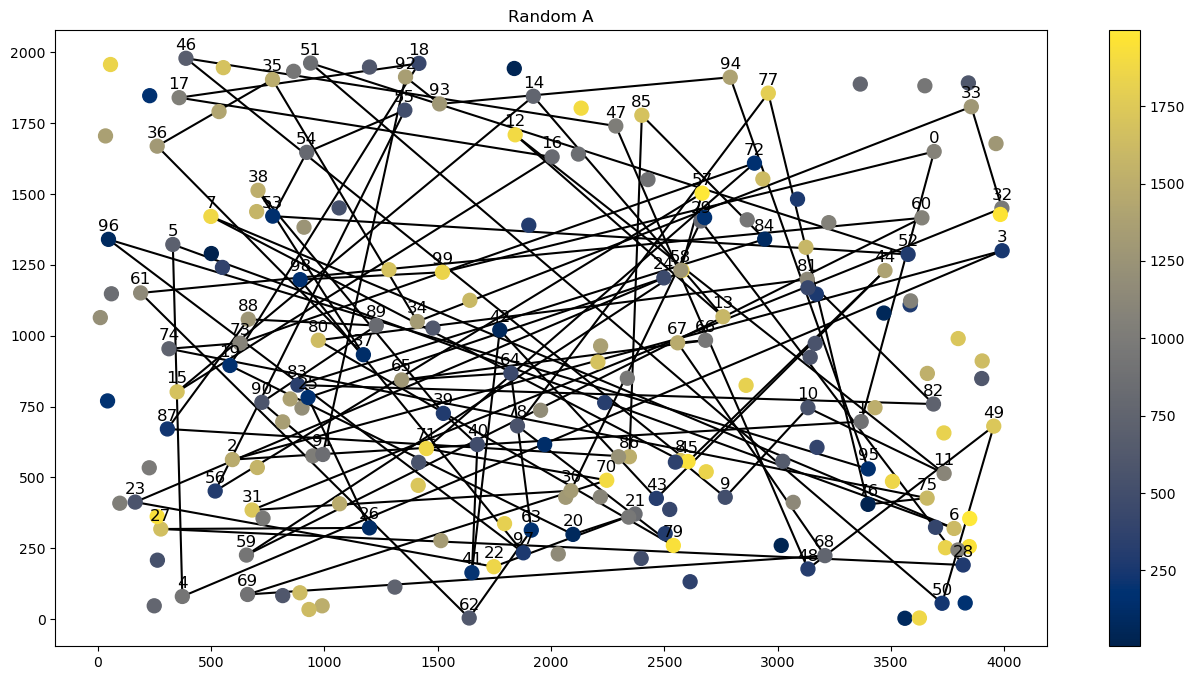

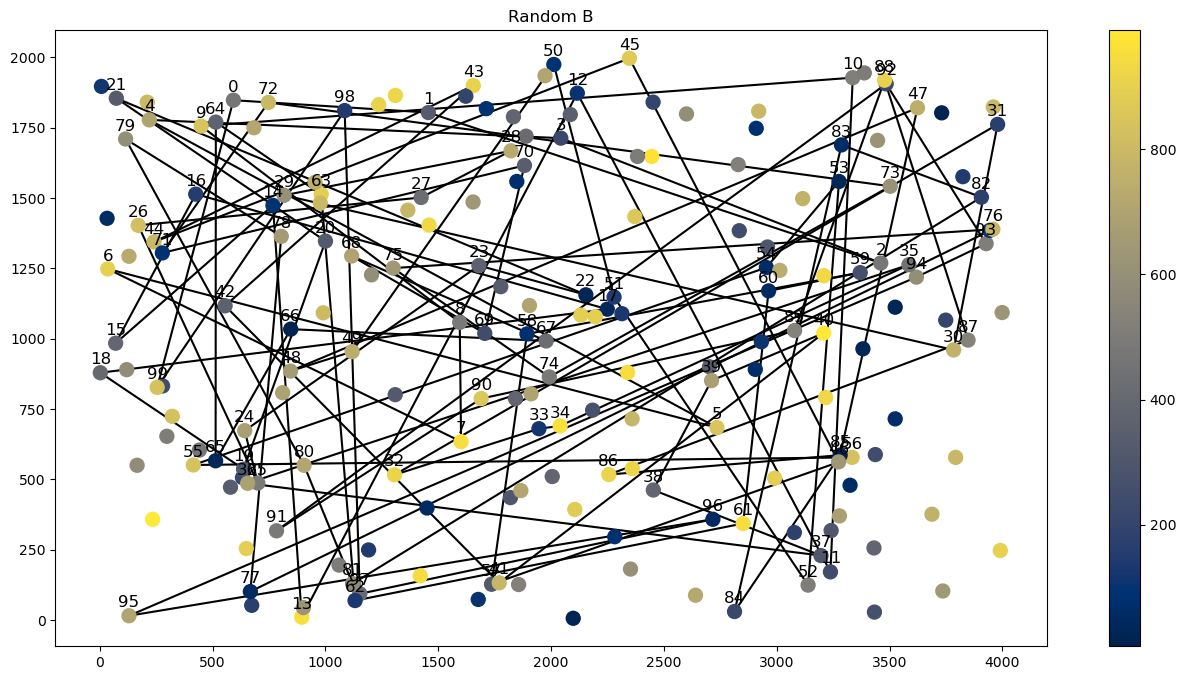

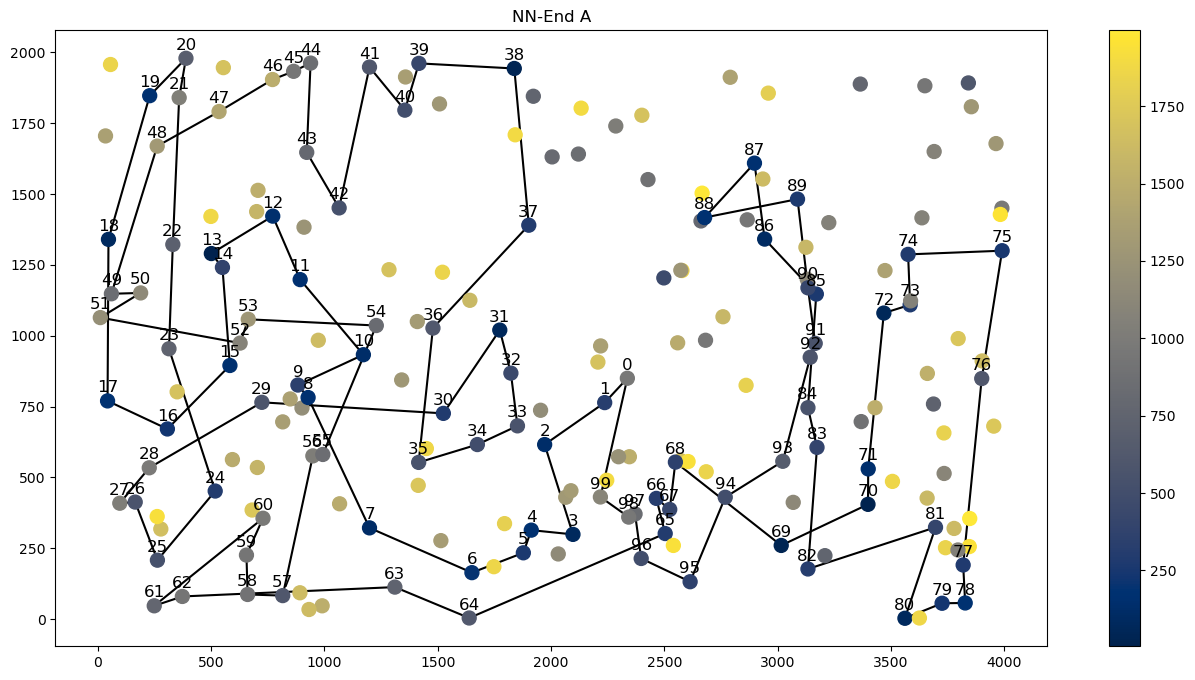

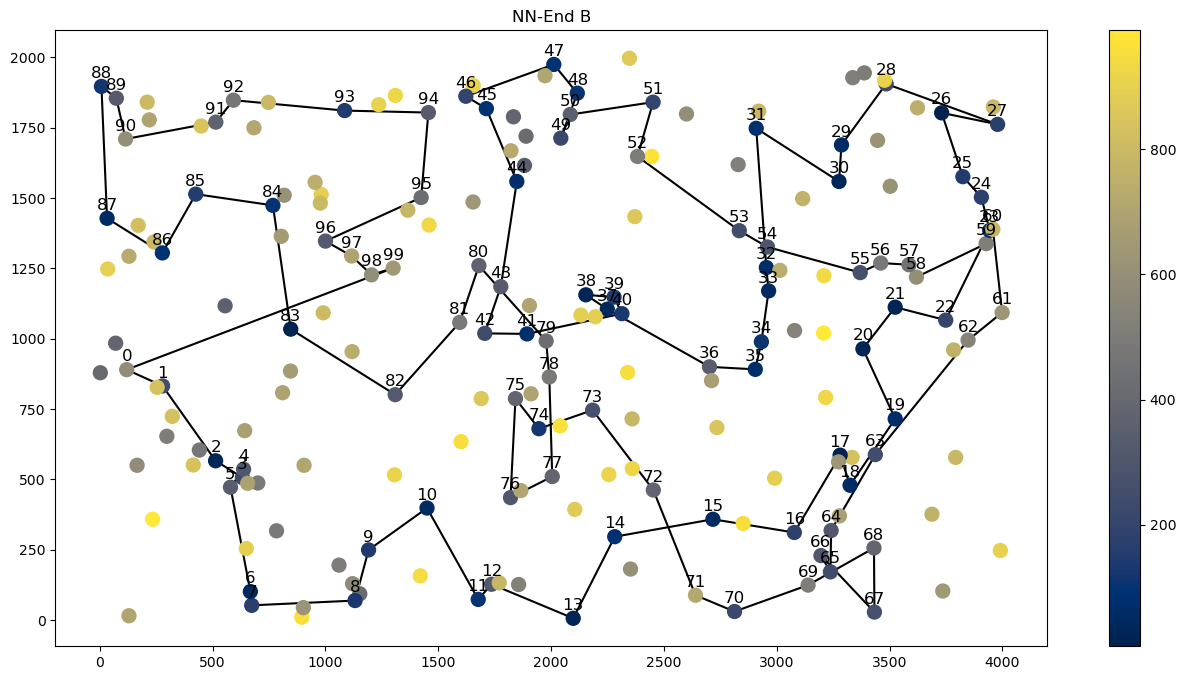

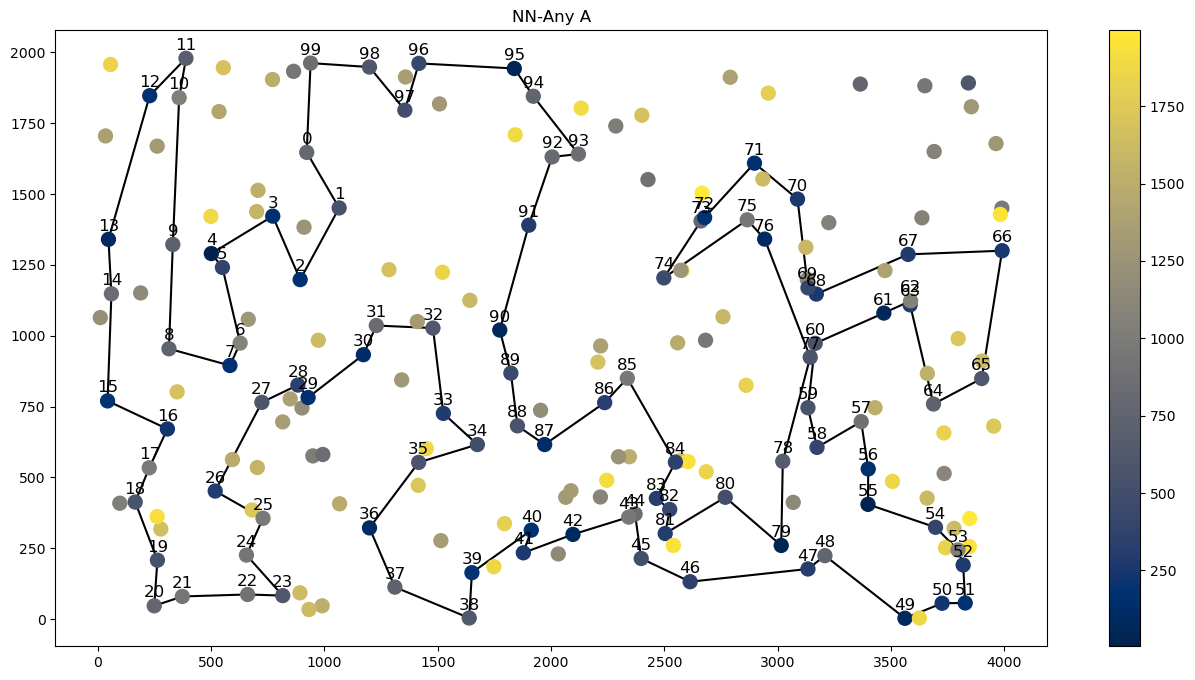

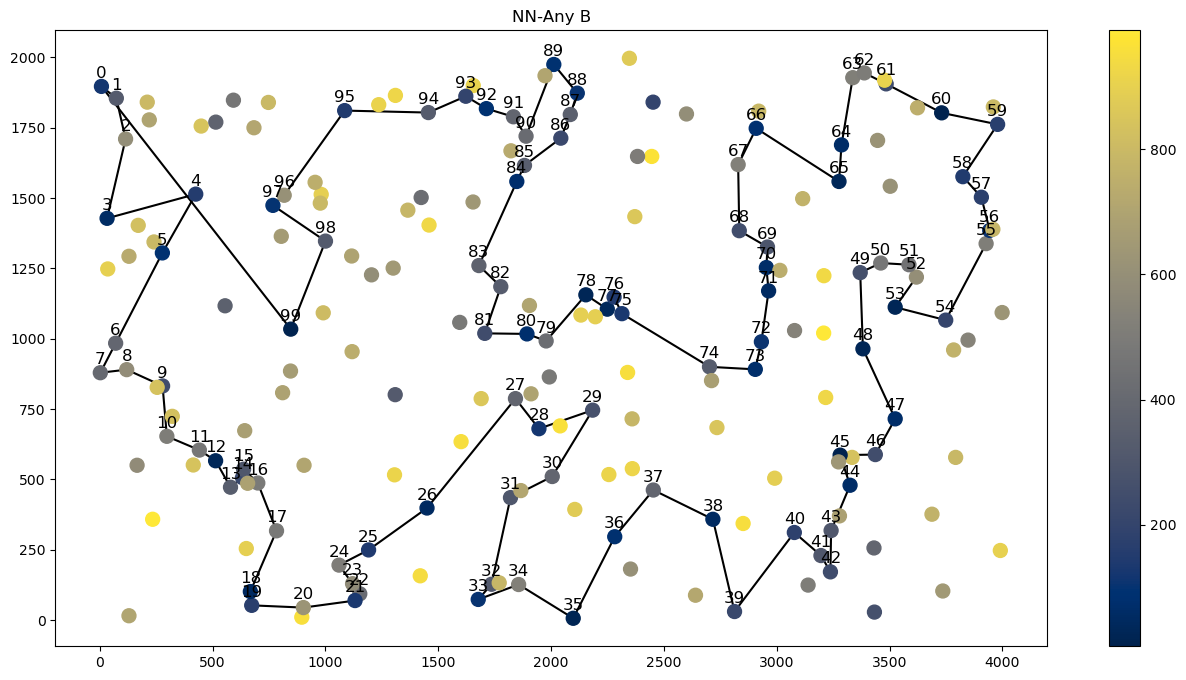

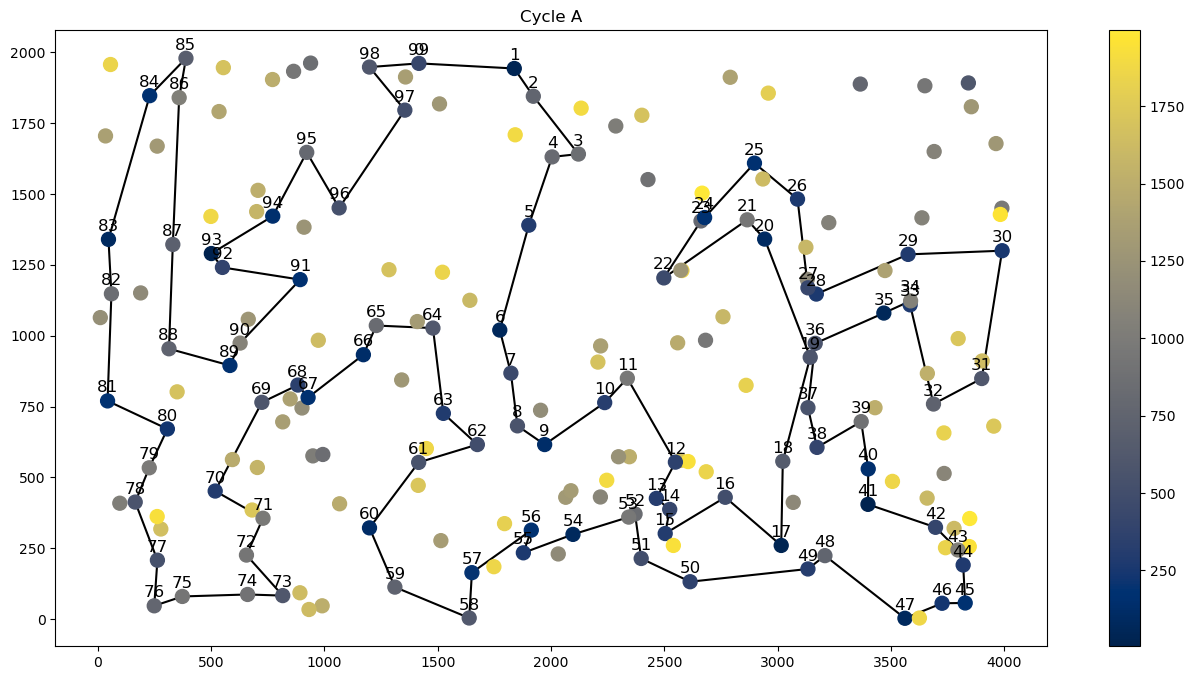

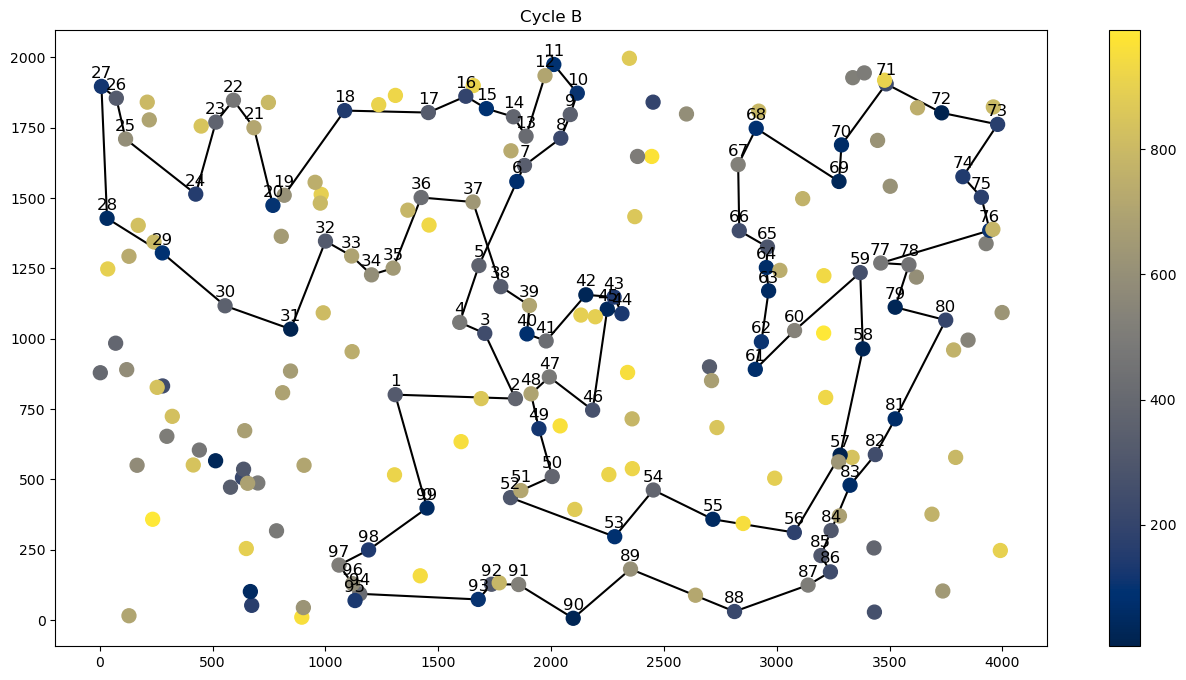

In [9]:
for index, ((_, _, _, solution), name) in enumerate(zip(experiments, columns)):
    if index % 2 == 0:
        tsp_a.plot(solution, name)
    else:
        tsp_b.plot(solution, name)

# Conclusions:

- Best method for instance A greedy cycle, but for an instance B was NN-end
- Random solution didn't have a luck even for such small sample of nodes and work much worse
- Average cost for an instance is almost two times higher for instance B, which can be an explanation, why the results of heuristics give us lower overall cost
- Average cost for an instance A and B was the lowest for NN-Any, but the highest was for NN-End also for both instances
- Maximum cost for an instance A and B was significantly higher for NN-End, but was quite similar for NN-Any and Greedy Cycle
